# Modeling

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-Packages-and-Data" data-toc-modified-id="Load-Packages-and-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Packages and Data</a></span></li><li><span><a href="#Prepare-Training-Data-as-xgb.DMatrix" data-toc-modified-id="Prepare-Training-Data-as-xgb.DMatrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Training Data as <code>xgb.DMatrix</code></a></span><ul class="toc-item"><li><span><a href="#Choose-columns-to-use" data-toc-modified-id="Choose-columns-to-use-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Choose columns to use</a></span></li><li><span><a href="#Split-past-and-future-data" data-toc-modified-id="Split-past-and-future-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split <code>past</code> and <code>future</code> data</a></span></li><li><span><a href="#Split-train-and-validation-data" data-toc-modified-id="Split-train-and-validation-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Split train and validation data</a></span></li><li><span><a href="#Transform-pd.DataFrame-to-xgb.DMatrix" data-toc-modified-id="Transform-pd.DataFrame-to-xgb.DMatrix-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Transform <code>pd.DataFrame</code> to <code>xgb.DMatrix</code></a></span></li></ul></li><li><span><a href="#XGBoost-Trial-Run" data-toc-modified-id="XGBoost-Trial-Run-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>XGBoost Trial Run</a></span><ul class="toc-item"><li><span><a href="#Train-XGB-model" data-toc-modified-id="Train-XGB-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train XGB model</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature importance</a></span></li><li><span><a href="#Create-a-submission" data-toc-modified-id="Create-a-submission-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Create a submission</a></span></li></ul></li><li><span><a href="#XGBoost-Manual-Tuning" data-toc-modified-id="XGBoost-Manual-Tuning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>XGBoost Manual Tuning</a></span></li><li><span><a href="#XGBoost-Auto-Tuning" data-toc-modified-id="XGBoost-Auto-Tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>XGBoost Auto Tuning</a></span></li></ul></div>

## Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb

In [2]:
import pickle
with open('scratch/variables.pkl', 'rb') as f:
    (cat_cols, num_cols, bin_cols, id_col, target_col, 
    cat2int_cols, cat2int_encoders, cat2onehot_cols, 
    cat2onehot_sparse) = pickle.load(f)

In [3]:
full = pd.read_pickle('scratch/full_engineered.pkl')

In [4]:
display(full.info())
display(full.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284127 entries, 0 to 284126
Data columns (total 53 columns):
dataset                      284127 non-null object
air_store_id                 284127 non-null object
id                           284127 non-null object
visit_date                   284127 non-null datetime64[ns]
visitors                     284127 non-null int64
weekday                      284127 non-null int64
year                         284127 non-null int64
month                        284127 non-null int64
day_of_year                  284127 non-null int64
days_in_month                284127 non-null int64
week_of_year                 284127 non-null int64
is_month_end                 284127 non-null bool
days_since_20160101          284127 non-null int64
holiday_flg                  284127 non-null int64
tomorrow_is_holiday          284127 non-null int32
yesterday_is_holiday         284127 non-null int32
air_genre_name               284127 non-null object
air_area_n

None

,dataset,air_store_id,id,visit_date,visitors,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
0,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-13,2016-01-13,25,2,2016,1,13,31,...,4,62,16,31,7,29,77,144,4222,7860
1,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-14,2016-01-14,32,3,2016,1,14,31,...,4,62,16,31,7,29,77,144,4223,7862
2,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-15,2016-01-15,29,4,2016,1,15,31,...,4,62,16,31,7,29,77,144,4224,7864
3,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-16,2016-01-16,22,5,2016,1,16,31,...,4,62,16,31,7,29,77,144,4225,7866
4,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-18,2016-01-18,6,0,2016,1,18,31,...,4,62,16,31,7,29,77,144,4220,7858


## Prepare Training Data as `xgb.DMatrix`

### Choose columns to use

Just use the numeric columns and integer-encoded categoricals...

In [5]:
use_cols = num_cols + bin_cols + cat2int_cols
print(use_cols)

['weekday', 'year', 'month', 'day_of_year', 'days_in_month', 'week_of_year', 'days_since_20160101', 'latitude_air', 'longitude_air', 'n_stores_same_street', 'n_stores_same_city', 'n_stores_same_Todofuken', 'n_reserves', 'n_reserve_visitors', 'reserve_avg_hours_ahead', 'mean_visitors', 'median_visitors', 'min_visitors', 'max_visitors', 'is_month_end', 'holiday_flg', 'tomorrow_is_holiday', 'yesterday_is_holiday', 'air_store_id_int', 'air_genre_name_int', 'air_area_name_int', 'hpg_genre_name_int', 'hpg_area_name_int', 'Todofuken_int', 'city_int', 'street_int', 'area_genre_int', 'store_weekday_int', 'store_weekday_holiday_int']


### Split `past` and `future` data

In [6]:
past = full.query('dataset=="past"')
future  = full.query('dataset=="future"')

print('Past data set:')
display(past.shape)
display(past.head())

print('Future data set:')
display(future.shape)
display(future.head())

Past data set:


(252108, 53)

,dataset,air_store_id,id,visit_date,visitors,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
0,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-13,2016-01-13,25,2,2016,1,13,31,...,4,62,16,31,7,29,77,144,4222,7860
1,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-14,2016-01-14,32,3,2016,1,14,31,...,4,62,16,31,7,29,77,144,4223,7862
2,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-15,2016-01-15,29,4,2016,1,15,31,...,4,62,16,31,7,29,77,144,4224,7864
3,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-16,2016-01-16,22,5,2016,1,16,31,...,4,62,16,31,7,29,77,144,4225,7866
4,past,air_ba937bf13d40fb24,air_ba937bf13d40fb24_2016-01-18,2016-01-18,6,0,2016,1,18,31,...,4,62,16,31,7,29,77,144,4220,7858


Future data set:


(32019, 53)

,dataset,air_store_id,id,visit_date,visitors,weekday,year,month,day_of_year,days_in_month,...,air_genre_name_int,air_area_name_int,hpg_genre_name_int,hpg_area_name_int,Todofuken_int,city_int,street_int,area_genre_int,store_weekday_int,store_weekday_holiday_int
252108,future,air_00a91d42b08b08d9,air_00a91d42b08b08d9_2017-04-23,2017-04-23,0,6,2017,4,113,30,...,6,44,16,31,7,5,45,102,6,11
252109,future,air_00a91d42b08b08d9,air_00a91d42b08b08d9_2017-04-24,2017-04-24,0,0,2017,4,114,30,...,6,44,16,31,7,5,45,102,0,0
252110,future,air_00a91d42b08b08d9,air_00a91d42b08b08d9_2017-04-25,2017-04-25,0,1,2017,4,115,30,...,6,44,16,31,7,5,45,102,1,2
252111,future,air_00a91d42b08b08d9,air_00a91d42b08b08d9_2017-04-26,2017-04-26,0,2,2017,4,116,30,...,6,44,16,31,7,5,45,102,2,3
252112,future,air_00a91d42b08b08d9,air_00a91d42b08b08d9_2017-04-27,2017-04-27,0,3,2017,4,117,30,...,6,44,16,31,7,5,45,102,3,5


### Split train and validation data

In [7]:
print(past.visit_date.min())
print(past.visit_date.max())

2016-01-01 00:00:00
2017-04-22 00:00:00


In [8]:
print(future.visit_date.min())
print(future.visit_date.max())

2017-04-23 00:00:00
2017-05-31 00:00:00


Train on an earlier dataset and validate on a future dataset.

In [9]:
train_selector = past.visit_date < '2017-02-01'
X_train = past[train_selector][use_cols]
y_train = past[train_selector][target_col].apply(np.log1p)    # apply np.log1p() (log(1+x)) to visitors count, to correct for high skewness

print('Training set dimensions...')
print('- X_train:', X_train.shape)
print('- y_train:', y_train.shape)

Training set dimensions...
- X_train: (194235, 34)
- y_train: (194235,)


In [10]:
val_selector = past.visit_date >= '2017-02-01'
X_val = past[val_selector][use_cols]
y_val = past[val_selector][target_col].apply(np.log1p)

print('Validation set dimensions...')
print('- X_val:', X_val.shape)
print('- y_val:', y_val.shape)

Validation set dimensions...
- X_val: (57873, 34)
- y_val: (57873,)


Train-validate ratio:

In [11]:
X_train.shape[0]/X_val.shape[0]

3.3562282929863665

Why log-tranform `y`'s?

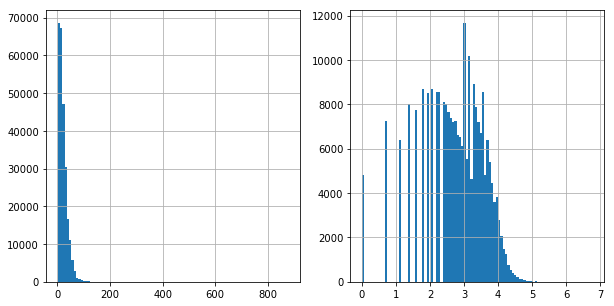

In [12]:
fg, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,5])
past[target_col].hist(bins=100, ax=ax[0])
past[target_col].apply(np.log).hist(bins=100, ax=ax[1])

### Transform `pd.DataFrame` to `xgb.DMatrix`

In [13]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
val_dmatrix = xgb.DMatrix(X_val, label=y_val)

eval_setting = [ (train_dmatrix, 'train'), (val_dmatrix, 'eval') ]

## XGBoost Trial Run

### Train XGB model

In [30]:
%%time

try_xgb_params = {'colsample_bytree': 0.4,
                  'eta': 0.1,
                  'gamma': 2,
                  'max_depth': 4,
                  'min_child_weight': 100,
                  'objective': 'reg:linear',
                  'seed': 2018,
                  'subsample': 1}

model = xgb.train(params=try_xgb_params,
                  dtrain=train_dmatrix, 
                  num_boost_round=100000, 
                  evals=eval_setting,
                  early_stopping_rounds=50,
                  verbose_eval=100
                 )

best_iteration = model.best_iteration
best_score = model.best_score

print ('best_score: {}, best_iteration: {}'.format(best_score, best_iteration))

[0]	train-rmse:2.21013	eval-rmse:2.22399
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.491168	eval-rmse:0.488732
[200]	train-rmse:0.487898	eval-rmse:0.488044
Stopping. Best iteration:
[190]	train-rmse:0.488206	eval-rmse:0.488012

best_score: 0.488012, best_iteration: 190
Wall time: 5.53 s


### Feature importance

,importance
day_of_year,0.180409
days_since_20160101,0.099677
mean_visitors,0.081922
max_visitors,0.060672
store_weekday_int,0.057138
air_store_id_int,0.053661
median_visitors,0.048180
week_of_year,0.031597
latitude_air,0.031125
street_int,0.030964


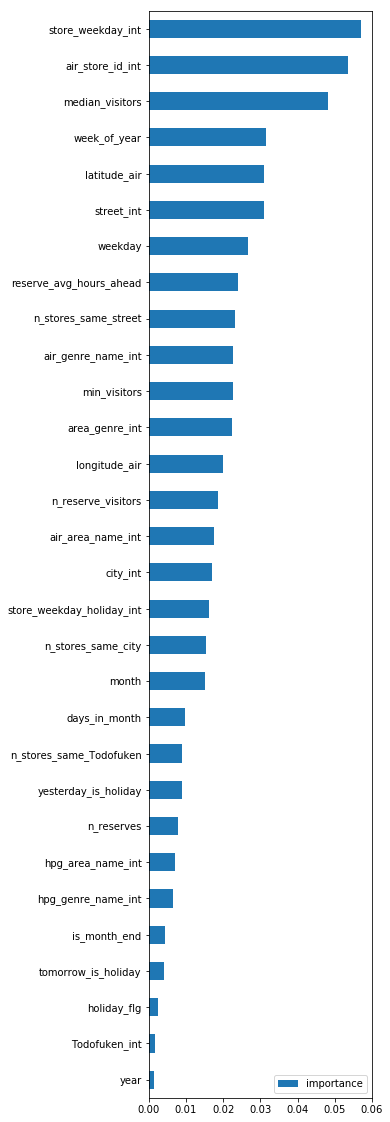

In [15]:
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance / feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot.barh(figsize=[4,20])
feature_importance.sort_values(by='importance', ascending=False).head(30)

### Create a submission

In [32]:
# train_selector = past.visit_date.between('2016-04-01', '2017-03-09')
X_train = past[use_cols]
y_train = past[target_col].apply(np.log1p)    # apply np.log1p() (log(1+x)) to visitors count, to correct for high skewness

print('Training set dimensions...')
print('- X_train:', X_train.shape)
print('- y_train:', y_train.shape)

Training set dimensions...
- X_train: (252108, 30)
- y_train: (252108,)


In [33]:
%%time
model = xgb.train(params=try_xgb_params, 
                  dtrain=xgb.DMatrix(X_train, label=y_train), 
                  num_boost_round=best_iteration*2
                 )

Wall time: 2h 8min 34s


In [34]:
future[target_col] = model.predict(xgb.DMatrix(future[use_cols]))
future[target_col] = future[target_col].apply(np.expm1).clip(lower=0.)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
sub = future[[id_col, target_col]].copy()

sub.to_csv('output/sub_xgb_try.csv', index=False)

## XGBoost Manual Tuning

XGBoost parameters doc: http://xgboost.readthedocs.io/en/latest/parameter.html

- `eta`: alias `learning_rate`. Step size. Smaller → learn slower, increase `num_round` to compensate.
- `gamma`: cost of a further partition. Larger `gamma` → simpler trees
- `colsample_bytree`: subsample ratio of columns when constructing each tree. Range (0,1]
- `subsample`: randomly select `subsample` portion of observations in training

In [16]:
basic_xgb_params = {
    'objective': 'reg:linear',
    'eta': 0.1,
    'seed': 2018
}

In [18]:
search_xgb_params = {
    'max_depth': [4, 8, 12, 16, 20, 24, 28, 32],
    'gamma': [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3],
    'colsample_bytree': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    'subsample': [0.1, 0.2, 0.4, 0.6, 0.8, 1],
    'min_child_weight': [0, 1, 3, 10, 20, 30, 50, 100]
}

In [19]:
%%time

best_params = basic_xgb_params.copy()
# start best_params with the basic params, 
# in each round, choose the best param found
# and add to best_params

for p in search_xgb_params:    # tune one parameter at each iteration, other parameters use default
    print('Tuning parameter {}, range: {}'.format(p, search_xgb_params[p]))
    test_params = best_params
    scores = []
    
    for v in search_xgb_params[p]:    # go thru each value of the parameter we're testing
        test_params[p] = v
        test_model = xgb.train(params=test_params, 
                               dtrain=train_dmatrix, 
                               num_boost_round=100000, 
                               evals=eval_setting,
                               early_stopping_rounds=50,
                               verbose_eval=False
                              )
        best_iter = test_model.best_iteration
        best_score = test_model.best_score
        scores.append([v, best_score])
        print('    {p}={v}: best_score={s}, best_iter={it}'.format(p=p, v=v, s=best_score, it=best_iter))
        
    scores.sort(key=lambda x: x[1])
    best_value = scores[0][0]
    best_score = scores[0][1]
    best_params[p] = best_value
    print('  Best value for {p}: {v} (score {s})'.format(p=p, v=best_value, s=best_score))
        
print(best_params)

Tuning parameter max_depth, range: [4, 8, 12, 16, 20, 24, 28, 32]
    max_depth=4: best_score=0.490789, best_iter=71
    max_depth=8: best_score=0.51696, best_iter=71
    max_depth=12: best_score=0.537223, best_iter=56
    max_depth=16: best_score=0.559336, best_iter=46
    max_depth=20: best_score=0.57631, best_iter=47
    max_depth=24: best_score=0.593558, best_iter=45
    max_depth=28: best_score=0.601077, best_iter=53
    max_depth=32: best_score=0.603654, best_iter=55
  Best value for max_depth: 4 (score 0.490789)
Tuning parameter gamma, range: [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3]
    gamma=0: best_score=0.490789, best_iter=71
    gamma=0.1: best_score=0.49079, best_iter=71
    gamma=0.2: best_score=0.49079, best_iter=71
    gamma=0.5: best_score=0.490786, best_iter=71
    gamma=1: best_score=0.490757, best_iter=71
    gamma=1.5: best_score=0.490311, best_iter=81
    gamma=2: best_score=0.490234, best_iter=84
    gamma=3: best_score=0.490999, best_iter=81
  Best value for gamma: 2 (sc

## XGBoost Auto Tuning

In [37]:
from bayes_opt import BayesianOptimization

In [38]:
def xgb_evaluate(min_child_weight, colsample_bytree, max_depth, subsample, gamma):
    params = {
        'objective': 'reg:linear',
        'eta': 0.1,
        'seed': 2018,
        'max_depth': int(max_depth),
        'min_child_weight': int(min_child_weight),
        'colsample_bytree': colsample_bytree,
        'subsample': subsample,
        'gamma': gamma
    }
    
    m = xgb.train(params=params, 
                  dtrain=train_dmatrix, 
                  num_boost_round=100000, 
                  evals=eval_setting,
                  early_stopping_rounds=50,
                  verbose_eval=False
                 )
    best_iter = m.best_iteration
    best_score= m.best_score
    return -best_score

In [39]:
xgb_BayesOpt = BayesianOptimization(f=xgb_evaluate, 
                                    pbounds={
                                        'max_depth': (3,10),
                                        'min_child_weight': (80, 120),
                                        'colsample_bytree': (0.2, 0.8),
                                        'subsample': (0.7, 1),
                                        'gamma': (0, 5)
                                    })

In [40]:
xgb_BayesOpt.maximize(init_points=8, n_iter=42)

Initialization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    1 | 00m07s |   -0.48737 |             0.7532 |    1.1945 |      4.4640 |            95.5622 |      0.8653 | 
    2 | 00m05s |   -0.48744 |             0.4021 |    0.3738 |      4.0390 |           102.8012 |      0.7919 | 
    3 | 00m04s |   -0.48816 |             0.3474 |    0.0075 |      5.6124 |            81.2147 |      0.8769 | 
    4 | 00m06s |   -0.48801 |             0.4275 |    3.4792 |      7.1607 |           108.5971 |      0.7754 | 
    5 | 00m06s |   -0.48755 |             0.7031 |    2.9267 |      4.4926 |           116.9816 |      0.8347 | 
    6 | 00m06s |   -0.48723 |             0.7890 |    2.1800 |      7.1604 |            92.2691 |      0.8894 | 
    7 | 00m05s |   -0.48736 |             0.4555 |    1.7771 |      6.1589 |      

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
---------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
    9 | 00m14s |   -0.48980 |             0.3616 |    0.2111 |      9.9839 |           119.8397 |      0.9702 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.27965905e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   10 | 00m21s |   -0.48845 |             0.2759 |    4.9324 |      3.8831 |            81.2472 |      0.9608 | 
   11 | 00m22s |   -0.48881 |             0.2075 |    4.8528 |      3.2559 |           116.6427 |      0.9984 | 
   12 | 00m19s |   -0.48729 |             0.6664 |    4.9332 |      9.9263 |            81.3907 |      0.7118 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.75826681e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   13 | 00m15s |   -0.48764 |             0.4272 |    0.5250 |      3.2017 |           119.9855 |      0.7000 | 
   14 | 00m18s |   -0.48891 |             0.7352 |    0.0267 |      9.6954 |            99.1570 |      0.7168 | 
   15 | 00m17s |   -0.48757 |             0.7377 |    0.1098 |      4.0187 |           112.8474 |      0.9968 | 
   16 | 00m19s |   -0.48817 |             0.7804 |    4.7214 |      3.5296 |           100.5519 |      0.7008 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -6.30617878e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   17 | 00m18s |   -0.49375 |             0.2039 |    4.8107 |      9.5086 |            88.6977 |      0.7446 | 
   18 | 00m21s |   -0.48837 |             0.7464 |    0.0384 |      9.5476 |            80.0878 |      0.9880 | 
   19 | 00m22s |   -0.48766 |             0.7558 |    3.0163 |      3.9771 |            80.0063 |      0.7349 | 
   20 | 00m23s |   -0.48697 |             0.7387 |    4.5002 |      5.7252 |           119.9611 |      0.9827 | 
   21 | 00m21s |   -0.48789 |             0.7984 |    4.5333 |      7.1526 |            80.2384 |      0.9777 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.99979204e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.08018061e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   22 | 00m21s |   -0.48783 |             0.7659 |    1.0555 |      3.1502 |            85.8864 |      0.7183 | 
   23 | 00m21s |   -0.48856 |             0.4653 |    4.8807 |      9.7583 |           119.9905 |      0.7804 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00023805]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   24 | 00m23s |   -0.48803 |             0.7884 |    3.5915 |      3.2183 |           106.3091 |      0.9938 | 
   25 | 00m21s |   -0.48764 |             0.7119 |    0.0366 |      6.9984 |            89.2615 |      0.7032 | 
   26 | 00m18s |   -0.49521 |             0.2018 |    3.6823 |      9.8187 |            80.1442 |      0.7550 | 
   27 | 00m21s |   -0.48786 |             0.7671 |    0.3592 |      3.4330 |            80.1691 |      0.9842 | 
   28 | 00m23s |   -0.48720 |             0.7839 |    4.8659 |      5.7430 |            85.3448 |      0.7318 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.95366327e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   29 | 00m23s |   -0.48805 |             0.7829 |    4.8735 |      9.7408 |           114.2469 |      0.9972 | 
   30 | 00m22s |   -0.48810 |             0.7952 |    0.1049 |      9.8114 |            84.5437 |      0.8956 | 
   31 | 00m29s |   -0.48771 |             0.7778 |    4.9412 |      9.4277 |            96.9391 |      0.7658 | 
   32 | 00m18s |   -0.48916 |             0.2364 |    0.0487 |      5.0405 |           119.6606 |      0.9845 | 
   33 | 00m21s |   -0.48759 |             0.7807 |    0.0316 |      9.5049 |           110.9471 |      0.7683 | 
   34 | 00m21s |   -0.48797 |             0.7632 |    4.9131 |      4.9758 |           112.8323 |      0.7078 | 
   35 | 00m21s |   -0.48759 |             0.7972 |    0.0628 |      7.3818 |           106.1568 |      0.9497 | 
   36 | 00m23s |   -0.48788 |             0.8000 |    4.9320 |      3.7381 |            80.8362 |      0.7188 | 
   37 | 00m23s |   -0.48839 |             0.2839 |    4.8378 |      3.0516 |           119.8832 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.02685972e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


   38 | 00m25s |   -0.48880 |             0.2257 |    4.7743 |      3.1772 |            93.0617 |      0.8689 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00136222]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   39 | 00m21s |   -0.48845 |             0.2266 |    0.1934 |      3.1897 |           108.3066 |      0.7582 | 
   40 | 00m22s |   -0.48758 |             0.7993 |    0.2968 |      8.3858 |           119.4530 |      0.7007 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0002904]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   41 | 00m24s |   -0.48728 |             0.7776 |    4.9754 |      9.6473 |            83.9095 |      0.9579 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00086765]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.44747298e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


   42 | 00m20s |   -0.48743 |             0.7916 |    0.4879 |      5.5375 |            82.8915 |      0.7068 | 
   43 | 00m21s |   -0.48852 |             0.2249 |    0.0854 |      3.0288 |            91.3948 |      0.9515 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00019312]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  8.93314136e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   44 | 00m25s |   -0.48735 |             0.7914 |    4.6294 |      9.8351 |           108.7833 |      0.7248 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00037127]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)


   45 | 00m23s |   -0.48826 |             0.7370 |    0.0590 |      9.8856 |            92.5491 |      0.8380 | 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00106304]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   46 | 00m22s |   -0.48768 |             0.7888 |    3.3866 |      9.5119 |           119.8938 |      0.9746 | 
   47 | 00m24s |   -0.48753 |             0.7824 |    4.8822 |      6.2632 |           105.7364 |      0.7501 | 
   48 | 00m21s |   -0.48698 |             0.7987 |    2.1645 |      5.7546 |           103.6166 |      0.7271 | 
   49 | 00m21s |   -0.48733 |             0.7426 |    4.9548 |      5.9312 |            97.3191 |      0.9780 | 
   50 | 00m23s |   -0.48792 |             0.7990 |    0.0117 |      3.0649 |           119.3412 |      0.8772 | 


In [53]:
xgb_test_params = pd.DataFrame(xgb_BayesOpt.res['all']['params'])
xgb_test_params['score'] = np.negative(xgb_BayesOpt.res['all']['values'])
xgb_test_params.sort_values(by='score', inplace=True)

In [58]:
xgb_test_params.loc[0,:].drop('score').to_dict()

{'colsample_bytree': 0.36157415502133555,
 'gamma': 0.21107436602789964,
 'max_depth': 9.9838780872348316,
 'min_child_weight': 119.8396995179726,
 'subsample': 0.9702118748217563}

In [60]:
xgb_BayesOpt.res

{'all': {'params': [{'colsample_bytree': 0.36157415502133555,
    'gamma': 0.21107436602789964,
    'max_depth': 9.9838780872348316,
    'min_child_weight': 119.8396995179726,
    'subsample': 0.9702118748217563},
   {'colsample_bytree': 0.27592872895384901,
    'gamma': 4.932414410836051,
    'max_depth': 3.8831330213325899,
    'min_child_weight': 81.247168455196146,
    'subsample': 0.96076411415733309},
   {'colsample_bytree': 0.20747511816149714,
    'gamma': 4.8527886544921195,
    'max_depth': 3.2559037070760666,
    'min_child_weight': 116.64271308380299,
    'subsample': 0.99841794387399774},
   {'colsample_bytree': 0.66640132584403777,
    'gamma': 4.9331883659353535,
    'max_depth': 9.9263472088686022,
    'min_child_weight': 81.390652864711086,
    'subsample': 0.71182134393065932},
   {'colsample_bytree': 0.42720598254725395,
    'gamma': 0.52497620613009055,
    'max_depth': 3.2016586635488156,
    'min_child_weight': 119.98553211181553,
    'subsample': 0.70004716237013